# Step 1: Import Libraries


In [1]:

import sys
!{sys.executable} -m pip install --upgrade pip --user
!{sys.executable} -m pip install xlrd
!{sys.executable} -m pip install statsmodels
!{sys.executable} -m pip install requests
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import shutil
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import os
import requests
import sklearn as sc
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Downloading House Data

In [3]:
r = requests.get('https://www.dropbox.com/s/1fcws6aaodry54n/partii.zip?dl=1', allow_redirects=True)
open('partii.zip', 'wb').write(r.content);
with ZipFile('partii.zip', 'r') as zipObj:
   zipObj.extractall('DATA')
shutil.rmtree('DATA/__MACOSX')

In [4]:
df = pd.read_csv('DATA/house_dataset.csv').iloc[:,2:]

# Step 2: Exploratory Data Analysis (EDA)

In [5]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,NaN
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,NaN
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,NaN
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,NaN
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,NaN


In [6]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [7]:
numeric_features = df.select_dtypes(include=[np.number])
catagorical_features = df.select_dtypes(include="object")
print("No of Numerical Features ",len(numeric_features.columns))
print("No of catagorica Features ",len(catagorical_features.columns))

No of Numerical Features  38
No of catagorica Features  43


/home/junaid/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


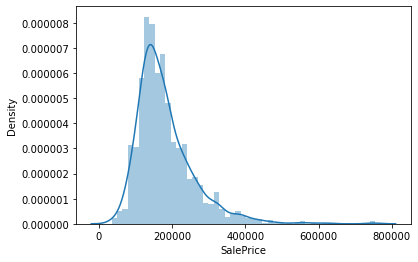

In [8]:
sns.distplot(df['SalePrice']);

Let’s have a more general view on the top 10 correlated features with the sale price:

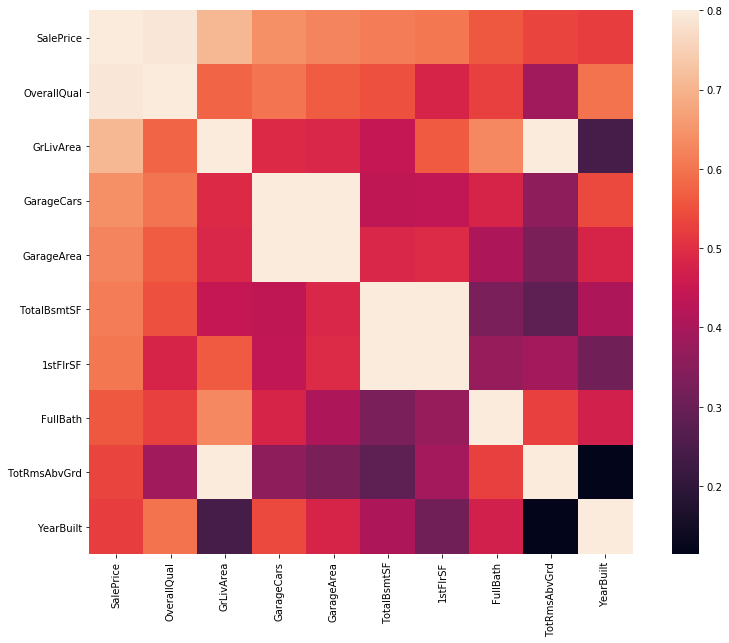

In [9]:
k = 10 #number of variables for heatmap
corrmat = df.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
f, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(df[cols].corr(), vmax=.8, square=True);

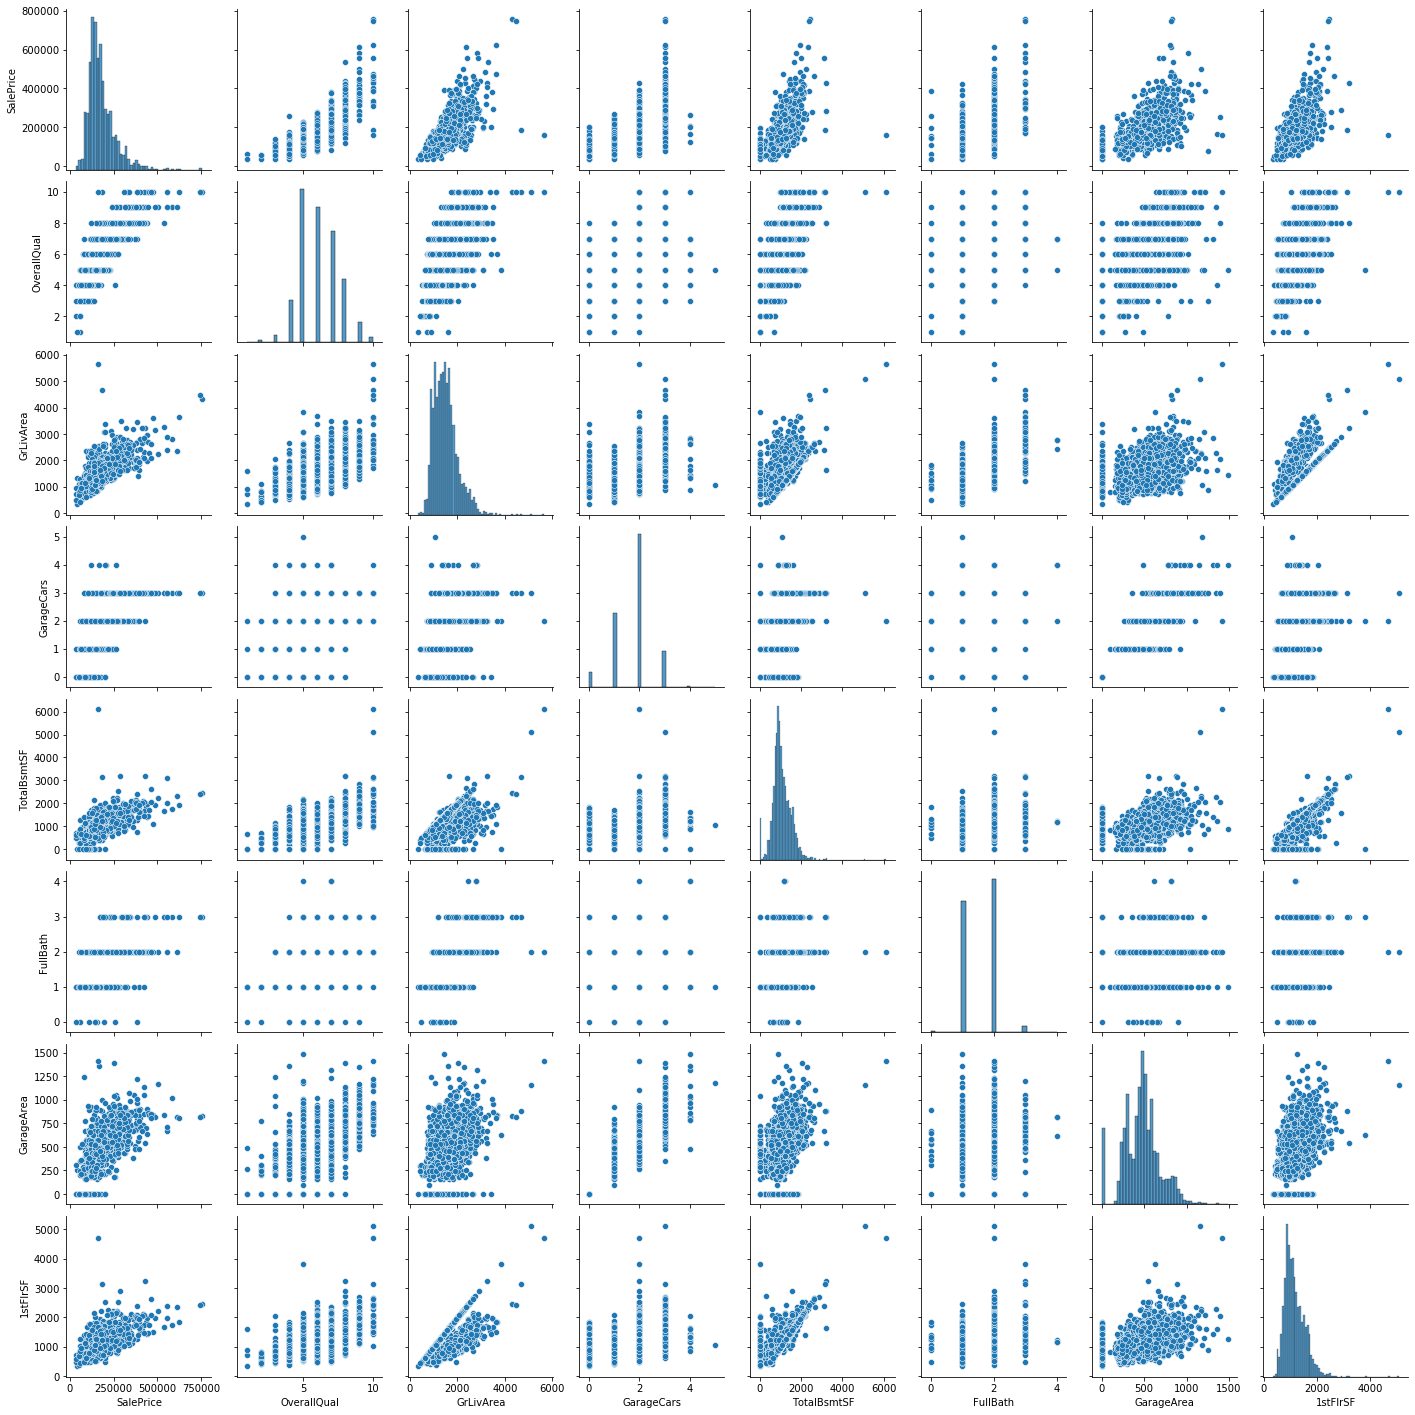

In [10]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath','GarageArea','1stFlrSF']
sns.pairplot(df[cols])
plt.show()

# Do we have missing data?

In [11]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
SalePrice,1459,0.499829
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


In [12]:
clean_data=df[cols]
clean_data.quantile([0.0, 0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 1.0])

,SalePrice,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,GarageArea,1stFlrSF
0.00,34900.00,1.0,334.00,0.0,0.00,0.0,0.00,334.00
0.01,61815.97,3.0,675.42,0.0,0.00,1.0,0.00,520.00
0.05,88000.00,4.0,861.00,0.0,455.25,1.0,0.00,665.90
0.10,106475.00,5.0,923.80,1.0,600.00,1.0,240.00,744.80
0.25,129975.00,5.0,1126.00,1.0,793.00,1.0,320.00,876.00
0.50,163000.00,6.0,1444.00,2.0,989.50,2.0,480.00,1082.00
0.75,214000.00,7.0,1743.50,2.0,1302.00,2.0,576.00,1387.50
0.90,278000.00,8.0,2153.20,3.0,1614.00,2.0,758.00,1675.00
0.95,326100.00,8.0,2464.20,3.0,1776.15,2.0,856.15,1830.10
0.99,442567.01,10.0,2935.72,3.0,2198.30,3.0,1019.49,2288.02


In [13]:
low = .01
high = .99

quant_df = clean_data.quantile([low, high])
quant_df.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,GarageArea,1stFlrSF
0.01,61815.97,3.0,675.42,0.0,0.0,1.0,0.00,520.00
0.99,442567.01,10.0,2935.72,3.0,2198.3,3.0,1019.49,2288.02


In [14]:
clean_data = clean_data.loc[(clean_data["GrLivArea"] < quant_df.loc[high, "GrLivArea"])&
                            (clean_data["TotalBsmtSF"] > quant_df.loc[low, "TotalBsmtSF"]) &
                            (clean_data["TotalBsmtSF"] < quant_df.loc[high, "TotalBsmtSF"]) &
                            (clean_data["GarageArea"] > quant_df.loc[low, "GarageArea"]) &
                            (clean_data["GarageArea"] < quant_df.loc[high, "GarageArea"])&
                            (clean_data["1stFlrSF"] < quant_df.loc[high, "1stFlrSF"])&
                            (clean_data["SalePrice"] > quant_df.loc[low, "SalePrice"])&
                            (clean_data["SalePrice"] < quant_df.loc[high, "SalePrice"])]

In [15]:
X = clean_data.loc[:, ["OverallQual","GrLivArea","GarageCars","TotalBsmtSF","FullBath","GarageArea","1stFlrSF"]]
y = np.log(clean_data["SalePrice"])

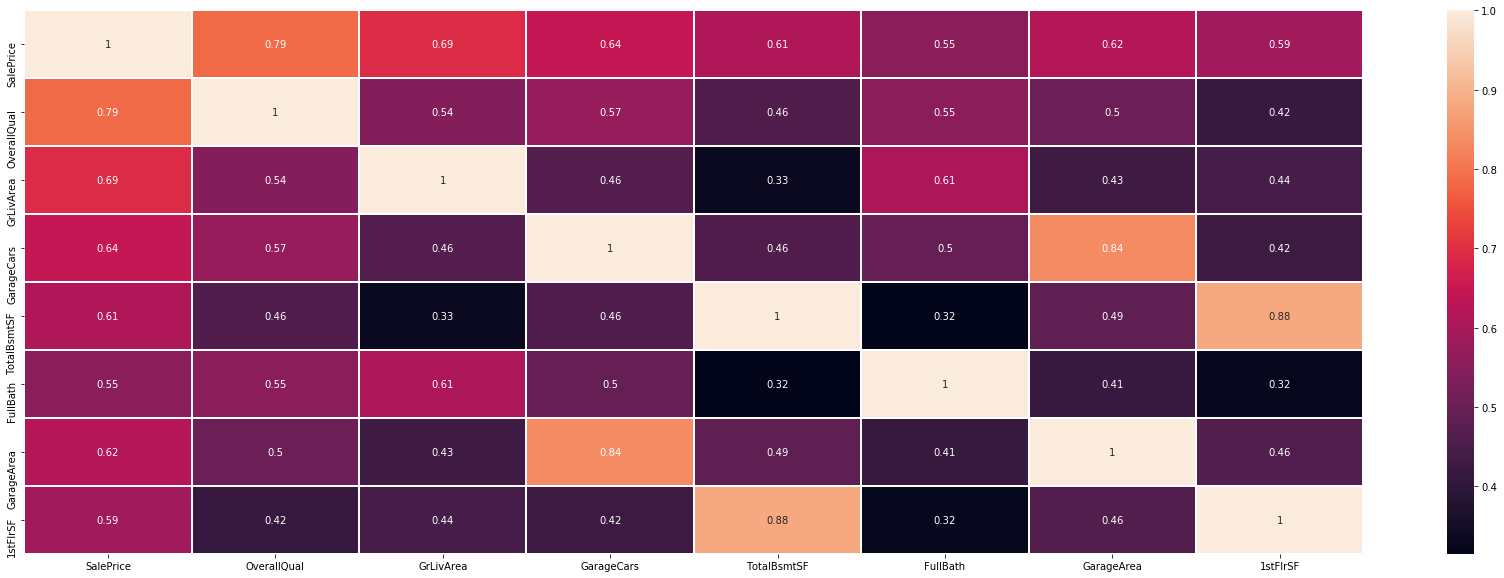

In [16]:
plt.figure(figsize=(30,10))
sns.heatmap(clean_data.corr(), linewidth=1, annot=True)
plt.show()

## Preparing the data

### Feature scaling

We will do a little preprocessing to our data using the following formula (standardization):

$$x'= \frac{x - \mu}{\sigma}$$

where $\mu$ is the population mean and $\sigma$ is the standard deviation.



In [17]:
X = (X - X.mean()) / X.std()
X = np.c_[np.ones(X.shape[0]), X] 

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 50)

## Linear Regression

### Simple Linear Regression

Simple linear regression uses a traditional slope-intercept form, where $a$ and $b$ are the coefficients that we try to “learn” and produce the most accurate predictions. $X$ represents our input data and $Y$ is our prediction.

$$Y = bX + a$$

![](https://spss-tutorials.com/img/simple-linear-regression-equation-linear-relation.png)


### Multivariable Regression

A more complex, multi-variable linear equation might look like this, where w represents the coefficients, or weights, our model will try to learn.

$$ Y(x_1,x_2,x_3) = w_1 x_1 + w_2 x_2 + w_3 x_3 + w_0$$

The variables $x_1, x_2, x_3$ represent the attributes, or distinct pieces of information, we have about each observation.

In [19]:
lm = LinearRegression()
lm.fit(x_train, y_train)
print("Coefficients: ", lm.coef_)

result = lm.predict(x_test)

Coefficients:  [ 0.          0.13065804  0.11642741  0.03006242  0.07691202  0.00802758
  0.03020288 -0.00485464]


Text(0, 0.5, 'Predicted values')

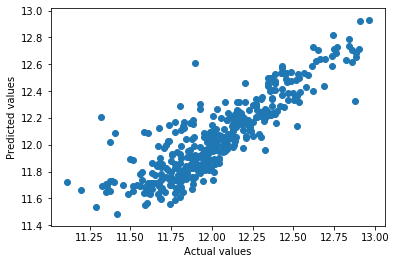

In [20]:
plt.scatter(y_test, result)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")

In [21]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     725.0
Date:                Wed, 16 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:25:48   Log-Likelihood:                 590.35
No. Observations:                1298   AIC:                            -1165.
Df Residuals:                    1290   BIC:                            -1123.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0472      0.004   2818.002      0.0